## Training Deep Neural Networks

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Vanishing/Exploding Gradients Problem

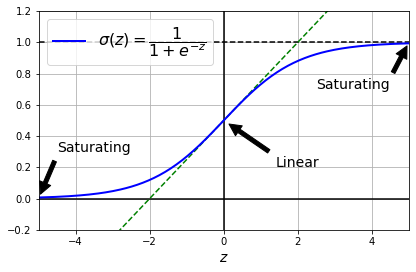

In [5]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

save_fig("sigmoid_saturation_plot")
plt.show()

In [6]:
dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

In [7]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

## Nonsaturating Activation Functions

### Leaky ReLU

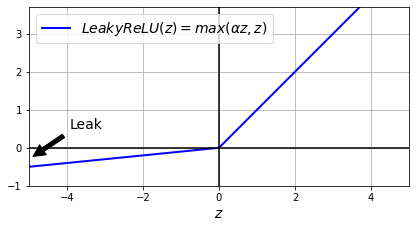

In [8]:
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

save_fig("leaky_relu_plot")
plt.show()

In [9]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

In [10]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

### ELU

In [11]:

dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

### SELU

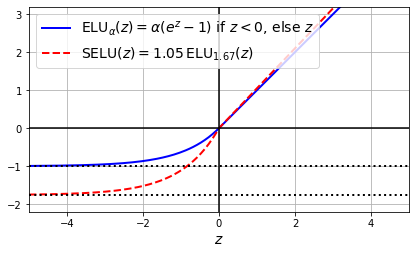

In [12]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

save_fig("elu_selu_plot")
plt.show()

In [13]:

dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

In [14]:
#Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [15]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [16]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [17]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [18]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [19]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 49s 25ms/step - loss: 1.3882 - accuracy: 0.4661 - val_loss: 1.0165 - val_accuracy: 0.6300
Epoch 2/5
1719/1719 [==============================] - 41s 24ms/step - loss: 1.0129 - accuracy: 0.6189 - val_loss: 0.7903 - val_accuracy: 0.7162
Epoch 3/5
1719/1719 [==============================] - 41s 24ms/step - loss: 0.8948 - accuracy: 0.6563 - val_loss: 0.9159 - val_accuracy: 0.6546
Epoch 4/5
1719/1719 [==============================] - 42s 24ms/step - loss: 0.7816 - accuracy: 0.6991 - val_loss: 0.6921 - val_accuracy: 0.7580
Epoch 5/5
1719/1719 [==============================] - 39s 23ms/step - loss: 0.6789 - accuracy: 0.7501 - val_loss: 0.7105 - val_accuracy: 0.7340


In [20]:
tf.random.set_seed(42)

In [21]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [22]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [23]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 41s 20ms/step - loss: 1.8777 - accuracy: 0.2680 - val_loss: 1.7443 - val_accuracy: 0.2398
Epoch 2/5
1719/1719 [==============================] - 33s 19ms/step - loss: 1.2755 - accuracy: 0.4653 - val_loss: 1.0164 - val_accuracy: 0.5776
Epoch 3/5
1719/1719 [==============================] - 28s 17ms/step - loss: 1.0491 - accuracy: 0.5749 - val_loss: 0.8938 - val_accuracy: 0.6380
Epoch 4/5
1719/1719 [==============================] - 24s 14ms/step - loss: 1.0914 - accuracy: 0.5689 - val_loss: 0.9559 - val_accuracy: 0.6438
Epoch 5/5
1719/1719 [==============================] - 25s 15ms/step - loss: 0.8713 - accuracy: 0.6519 - val_loss: 0.8505 - val_accuracy: 0.6802


The Gaussian Error Linear Unit, or GELU, is an activation function. The GELU activation function is , where the standard Gaussian cumulative distribution function. The GELU nonlinearity weights inputs by their percentile, rather than gates inputs by their sign as in ReLUs. Consequently the GELU can be thought of as a smoother ReLU.

PyTorch's exact implementation is sufficiently fast such that these approximations may be unnecessary. (See also the SiLU which was also coined in the paper that introduced the GELU.)

GELUs are used in GPT-3, BERT, and most other Transformers.

Swish is an activation function,  f(x) = x . sigmoid(beta . x) where beta a learnable parameter. Nearly all implementations do not use the learnable parameter, in which case the activation function is xsigma(x) ("Swish-1").

The function xsigma(x) is exactly the SiLU, which was introduced by other authors before the swish. See Gaussian Error Linear Units (GELUs) where the SiLU (Sigmoid Linear Unit) was originally coined, and see Sigmoid-Weighted Linear Units for Neural Network Function Approximation in Reinforcement Learning and Swish: a Self-Gated Activation Function where the same activation function was experimented with later.

Mish is an activation function for neural networks which can be defined as:
                                  f(x) = x tanh softplus(x)

where
                                    softplus(x) = ln(1+e^x)

(Compare with functionally similar previously proposed activation functions such as the GELU and the SiLU.)

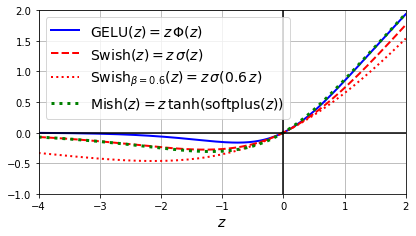

In [24]:
def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

save_fig("gelu_swish_mish_plot")
plt.show()

In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [28]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [29]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5423 - accuracy: 0.8082 - val_loss: 0.4009 - val_accuracy: 0.8506
Epoch 2/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4024 - accuracy: 0.8554 - val_loss: 0.3618 - val_accuracy: 0.8688


Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a BatchNormalization layer does not need to have bias terms, since the BatchNormalization layer some as well, it would be a waste of parameters, so you can set use_bias=False when creating those layers:

In [30]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [32]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5996 - accuracy: 0.7990 - val_loss: 0.4216 - val_accuracy: 0.8466
Epoch 2/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4230 - accuracy: 0.8518 - val_loss: 0.3705 - val_accuracy: 0.8656


## Gradient Clipping

In [33]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reusing Pretrained Layers

### Reusing a Keras model

Let's split the fashion MNIST training set in two:

X_train_A: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
X_train_B: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.
The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using Dense layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 14).

In [34]:
pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 4s 3ms/step - loss: 1.1454 - accuracy: 0.6461 - val_loss: 0.6862 - val_accuracy: 0.7726
Epoch 2/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.6024 - accuracy: 0.8013 - val_loss: 0.5161 - val_accuracy: 0.8305
Epoch 3/20
1376/1376 [==============================] - 3s 3ms/step - loss: 0.4854 - accuracy: 0.8466 - val_loss: 0.4407 - val_accuracy: 0.8569
Epoch 4/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.4233 - accuracy: 0.8644 - val_loss: 0.3957 - val_accuracy: 0.8711
Epoch 5/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3849 - accuracy: 0.8747 - val_loss: 0.3687 - val_accuracy: 0.8752
Epoch 6/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3589 - accuracy: 0.8819 - val_loss: 0.3486 - val_accuracy: 0.8799
Epoch 7/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3409 - accuracy: 0.8862 - val_loss: 0.3345 - val_accuracy:

In [35]:
tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 1s 44ms/step - loss: 0.6550 - accuracy: 0.6700 - val_loss: 0.6272 - val_accuracy: 0.7804
Epoch 2/20
7/7 [==============================] - 0s 16ms/step - loss: 0.6341 - accuracy: 0.7500 - val_loss: 0.6087 - val_accuracy: 0.8249
Epoch 3/20
7/7 [==============================] - 0s 20ms/step - loss: 0.6148 - accuracy: 0.7850 - val_loss: 0.5904 - val_accuracy: 0.8526
Epoch 4/20
7/7 [==============================] - 0s 18ms/step - loss: 0.5947 - accuracy: 0.8200 - val_loss: 0.5739 - val_accuracy: 0.8724
Epoch 5/20
7/7 [==============================] - 0s 24ms/step - loss: 0.5772 - accuracy: 0.8350 - val_loss: 0.5564 - val_accuracy: 0.8971
Epoch 6/20
7/7 [==============================] - 0s 14ms/step - loss: 0.5583 - accuracy: 0.8500 - val_loss: 0.5391 - val_accuracy: 0.9110
Epoch 7/20
7/7 [==============================] - 0s 17ms/step - loss: 0.5394 - accuracy: 0.8600 - val_loss: 0.5227 - val_accuracy: 0.9228
Epoch 8/20
7/7 [===========

[0.37310025095939636, 0.9355000257492065]

Model B reached 93% of accuracy on the test set

In [36]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that model_B_on_A and model_A actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build model_B_on_A on top of a clone of model_A:

In [37]:
tf.random.set_seed(42)  # extra code – ensure reproducibility

In [38]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [39]:
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [40]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [41]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 50ms/step - loss: 0.7721 - accuracy: 0.4950 - val_loss: 0.6501 - val_accuracy: 0.6202
Epoch 2/4
7/7 [==============================] - 0s 26ms/step - loss: 0.6013 - accuracy: 0.6900 - val_loss: 0.5987 - val_accuracy: 0.7260
Epoch 3/4
7/7 [==============================] - 0s 21ms/step - loss: 0.5606 - accuracy: 0.7900 - val_loss: 0.5914 - val_accuracy: 0.7349
Epoch 4/4
7/7 [==============================] - 0s 21ms/step - loss: 0.5471 - accuracy: 0.7900 - val_loss: 0.5860 - val_accuracy: 0.7409
Epoch 1/16
7/7 [==============================] - 1s 64ms/step - loss: 0.5320 - accuracy: 0.7950 - val_loss: 0.5619 - val_accuracy: 0.7478
Epoch 2/16
7/7 [==============================] - 0s 24ms/step - loss: 0.5085 - accuracy: 0.8150 - val_loss: 0.5155 - val_accuracy: 0.8229
Epoch 3/16
7/7 [==============================] - 0s 23ms/step - loss: 0.4657 - accuracy: 0.8800 - val_loss: 0.4980 - val_accuracy: 0.8091
Epoch 4/16
7/7 [===============

In [42]:
model_B_on_A.evaluate(X_test_B, y_test_B) #not getting the transfer increase 

63/63 [==============================] - 0s 2ms/step - loss: 0.3278 - accuracy: 0.9155


[0.32777872681617737, 0.9154999852180481]

In [44]:
1 - (100 - 93.85) / (100 - 91.85)

0.24539877300613477

In [54]:
import keras 
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [48]:
X_train_A.shape

(43970, 28, 28)

In [49]:
X_train_B.shape

(200, 28, 28)

In [50]:
y_train_A[:30]

array([7, 0, 0, 3, 0, 2, 5, 2, 0, 7, 5, 7, 1, 0, 4, 3, 1, 4, 6, 4, 3, 0,
       2, 4, 4, 3, 0, 6, 2, 1], dtype=uint8)

In [51]:
y_train_B[:30]

array([0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0.], dtype=float32)

In [52]:
tf.random.set_seed(42)
np.random.seed(42)

In [55]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [56]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [57]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 8s 5ms/step - loss: 0.5536 - accuracy: 0.8232 - val_loss: 0.3684 - val_accuracy: 0.8732
Epoch 2/20
1375/1375 [==============================] - 7s 5ms/step - loss: 0.3484 - accuracy: 0.8801 - val_loss: 0.3472 - val_accuracy: 0.8677
Epoch 3/20
1375/1375 [==============================] - 7s 5ms/step - loss: 0.3143 - accuracy: 0.8914 - val_loss: 0.3089 - val_accuracy: 0.8903
Epoch 4/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2955 - accuracy: 0.8973 - val_loss: 0.2944 - val_accuracy: 0.8938
Epoch 5/20
1375/1375 [==============================] - 6s 5ms/step - loss: 0.2829 - accuracy: 0.9023 - val_loss: 0.2805 - val_accuracy: 0.9000
Epoch 6/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2733 - accuracy: 0.9064 - val_loss: 0.2675 - val_accuracy: 0.9042
Epoch 7/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2654 - accuracy: 0.9083 - val_loss: 0.2670 - val_accuracy:

In [60]:
model_A.save("my_model_A.h5")

In [61]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [62]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [63]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 47ms/step - loss: 0.7849 - accuracy: 0.4450 - val_loss: 0.7105 - val_accuracy: 0.6103
Epoch 2/20
7/7 [==============================] - 0s 21ms/step - loss: 0.6842 - accuracy: 0.6400 - val_loss: 0.6347 - val_accuracy: 0.7010
Epoch 3/20
7/7 [==============================] - 0s 23ms/step - loss: 0.6113 - accuracy: 0.7200 - val_loss: 0.5787 - val_accuracy: 0.7526
Epoch 4/20
7/7 [==============================] - 0s 21ms/step - loss: 0.5572 - accuracy: 0.7800 - val_loss: 0.5297 - val_accuracy: 0.7928
Epoch 5/20
7/7 [==============================] - 0s 19ms/step - loss: 0.5102 - accuracy: 0.8000 - val_loss: 0.4890 - val_accuracy: 0.8186
Epoch 6/20
7/7 [==============================] - 0s 22ms/step - loss: 0.4695 - accuracy: 0.8250 - val_loss: 0.4531 - val_accuracy: 0.8371
Epoch 7/20
7/7 [==============================] - 0s 24ms/step - loss: 0.4349 - accuracy: 0.8400 - val_loss: 0.4225 - val_accuracy: 0.8495
Epoch 8/20
7/7 [===========

In [64]:
model_B.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_19 (Dense)            (None, 300)               235500    
                                                                 
 dense_20 (Dense)            (None, 100)               30100     
                                                                 
 dense_21 (Dense)            (None, 50)                5050      
                                                                 
 dense_22 (Dense)            (None, 50)                2550      
                                                                 
 dense_23 (Dense)            (None, 50)                2550      
                                                                 
 dense_24 (Dense)            (None, 1)                

In [65]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [66]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [67]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [68]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 44ms/step - loss: 0.8008 - accuracy: 0.4900 - val_loss: 0.7936 - val_accuracy: 0.5031
Epoch 2/4
7/7 [==============================] - 0s 20ms/step - loss: 0.7526 - accuracy: 0.5400 - val_loss: 0.7496 - val_accuracy: 0.5371
Epoch 3/4
7/7 [==============================] - 0s 20ms/step - loss: 0.7098 - accuracy: 0.5950 - val_loss: 0.7091 - val_accuracy: 0.5732
Epoch 4/4
7/7 [==============================] - 0s 22ms/step - loss: 0.6702 - accuracy: 0.6150 - val_loss: 0.6701 - val_accuracy: 0.6093
Epoch 1/16
7/7 [==============================] - 1s 54ms/step - loss: 0.5675 - accuracy: 0.7200 - val_loss: 0.4794 - val_accuracy: 0.7856
Epoch 2/16
7/7 [==============================] - 0s 21ms/step - loss: 0.4079 - accuracy: 0.8450 - val_loss: 0.3674 - val_accuracy: 0.8990
Epoch 3/16
7/7 [==============================] - 0s 20ms/step - loss: 0.3134 - accuracy: 0.9550 - val_loss: 0.2979 - val_accuracy: 0.9340
Epoch 4/16
7/7 [===============

In [69]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.2097 - accuracy: 0.9585


[0.20971374213695526, 0.9585000276565552]

In [70]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.0891 - accuracy: 0.9900


[0.08906872570514679, 0.9900000095367432]

In [71]:
(100 - 97.05) / (100 - 99.40)

4.916666666666718

## Faster Optimizers

In [72]:
def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [73]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)


In [74]:
history_sgd = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7015 - accuracy: 0.7627 - val_loss: 0.4935 - val_accuracy: 0.8212
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4625 - accuracy: 0.8374 - val_loss: 0.4404 - val_accuracy: 0.8384
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4180 - accuracy: 0.8532 - val_loss: 0.4081 - val_accuracy: 0.8554
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3915 - accuracy: 0.8617 - val_loss: 0.3800 - val_accuracy: 0.8614
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3709 - accuracy: 0.8683 - val_loss: 0.3665 - val_accuracy: 0.8674
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3588 - accuracy: 0.8715 - val_loss: 0.3724 - val_accuracy: 0.8652
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3429 - accuracy: 0.8767 - val_loss: 0.3616 - val_accuracy:

## Momentum optimization

In [75]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)


In [76]:
history_momentum = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6976 - accuracy: 0.7613 - val_loss: 0.5187 - val_accuracy: 0.8144
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4720 - accuracy: 0.8348 - val_loss: 0.4572 - val_accuracy: 0.8330
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4269 - accuracy: 0.8495 - val_loss: 0.4265 - val_accuracy: 0.8510
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4002 - accuracy: 0.8589 - val_loss: 0.3935 - val_accuracy: 0.8582
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3775 - accuracy: 0.8663 - val_loss: 0.3795 - val_accuracy: 0.8644
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3641 - accuracy: 0.8698 - val_loss: 0.3891 - val_accuracy: 0.8594
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3479 - accuracy: 0.8743 - val_loss: 0.3766 - val_accuracy:

## Nesterov Accelerated Gradient

In [77]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [78]:
history_nesterov = build_and_train_model(optimizer) 

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6590 - accuracy: 0.7743 - val_loss: 0.4792 - val_accuracy: 0.8284
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4537 - accuracy: 0.8418 - val_loss: 0.4356 - val_accuracy: 0.8448
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4125 - accuracy: 0.8550 - val_loss: 0.3981 - val_accuracy: 0.8586
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3872 - accuracy: 0.8636 - val_loss: 0.3774 - val_accuracy: 0.8648
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3668 - accuracy: 0.8701 - val_loss: 0.3679 - val_accuracy: 0.8676
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3544 - accuracy: 0.8741 - val_loss: 0.3769 - val_accuracy: 0.8648
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3391 - accuracy: 0.8782 - val_loss: 0.3742 - val_accuracy:

## AdaGrad

In [79]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)


In [80]:
history_adagrad = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.9916 - accuracy: 0.6865 - val_loss: 0.6914 - val_accuracy: 0.7728
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6441 - accuracy: 0.7884 - val_loss: 0.5928 - val_accuracy: 0.7986
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5761 - accuracy: 0.8097 - val_loss: 0.5486 - val_accuracy: 0.8140
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5404 - accuracy: 0.8211 - val_loss: 0.5218 - val_accuracy: 0.8254
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5164 - accuracy: 0.8281 - val_loss: 0.5030 - val_accuracy: 0.8300
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4993 - accuracy: 0.8323 - val_loss: 0.4913 - val_accuracy: 0.8314
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4863 - accuracy: 0.8355 - val_loss: 0.4793 - val_accuracy:

## RMSProp

In [81]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)


In [82]:
history_rmsprop = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5140 - accuracy: 0.8146 - val_loss: 0.4425 - val_accuracy: 0.8298
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3921 - accuracy: 0.8593 - val_loss: 0.4380 - val_accuracy: 0.8372
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3661 - accuracy: 0.8691 - val_loss: 0.4057 - val_accuracy: 0.8650
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3619 - accuracy: 0.8755 - val_loss: 0.3811 - val_accuracy: 0.8716
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3593 - accuracy: 0.8765 - val_loss: 0.4027 - val_accuracy: 0.8584
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3576 - accuracy: 0.8780 - val_loss: 0.4414 - val_accuracy: 0.8580
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3629 - accuracy: 0.8781 - val_loss: 0.4303 - val_accuracy:

## Adam Optimization

In [83]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)

In [84]:
history_adam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4983 - accuracy: 0.8208 - val_loss: 0.4416 - val_accuracy: 0.8246
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3725 - accuracy: 0.8645 - val_loss: 0.3786 - val_accuracy: 0.8586
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3382 - accuracy: 0.8761 - val_loss: 0.3451 - val_accuracy: 0.8740
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3147 - accuracy: 0.8841 - val_loss: 0.3370 - val_accuracy: 0.8754
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2954 - accuracy: 0.8901 - val_loss: 0.3350 - val_accuracy: 0.8738
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2828 - accuracy: 0.8948 - val_loss: 0.3466 - val_accuracy: 0.8786
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2683 - accuracy: 0.8994 - val_loss: 0.3277 - val_accuracy:

### Adamax Optimization

In [85]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)

In [86]:
history_adamax = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5390 - accuracy: 0.8128 - val_loss: 0.4442 - val_accuracy: 0.8320
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3978 - accuracy: 0.8579 - val_loss: 0.3856 - val_accuracy: 0.8586
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3621 - accuracy: 0.8699 - val_loss: 0.3604 - val_accuracy: 0.8684
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3360 - accuracy: 0.8783 - val_loss: 0.3473 - val_accuracy: 0.8736
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3153 - accuracy: 0.8837 - val_loss: 0.3248 - val_accuracy: 0.8782
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3014 - accuracy: 0.8895 - val_loss: 0.3314 - val_accuracy: 0.8768
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2884 - accuracy: 0.8933 - val_loss: 0.3387 - val_accuracy:

### Nadam Optimization

In [87]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [88]:
history_nadam = build_and_train_model(optimizer) 

Epoch 1/10
1719/1719 [==============================] - 9s 4ms/step - loss: 0.4826 - accuracy: 0.8272 - val_loss: 0.4002 - val_accuracy: 0.8456
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3631 - accuracy: 0.8674 - val_loss: 0.3809 - val_accuracy: 0.8568
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3269 - accuracy: 0.8795 - val_loss: 0.3578 - val_accuracy: 0.8710
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3078 - accuracy: 0.8867 - val_loss: 0.3369 - val_accuracy: 0.8774
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2899 - accuracy: 0.8924 - val_loss: 0.3292 - val_accuracy: 0.8780
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2767 - accuracy: 0.8975 - val_loss: 0.3642 - val_accuracy: 0.8758
Epoch 7/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2647 - accuracy: 0.8996 - val_loss: 0.3548 - val_accuracy:

### AdamW Optimization


In [91]:
pip install -q -U tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [92]:
import tensorflow_addons as tfa

optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                 beta_1=0.9, beta_2=0.999)

In [93]:
history_adamw = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4947 - accuracy: 0.8221 - val_loss: 0.4245 - val_accuracy: 0.8356
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3740 - accuracy: 0.8629 - val_loss: 0.3796 - val_accuracy: 0.8538
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3413 - accuracy: 0.8750 - val_loss: 0.3437 - val_accuracy: 0.8738
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3203 - accuracy: 0.8820 - val_loss: 0.3382 - val_accuracy: 0.8766
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3010 - accuracy: 0.8878 - val_loss: 0.3302 - val_accuracy: 0.8780
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2863 - accuracy: 0.8929 - val_loss: 0.3444 - val_accuracy: 0.8774
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2757 - accuracy: 0.8964 - val_loss: 0.3250 - val_accuracy:

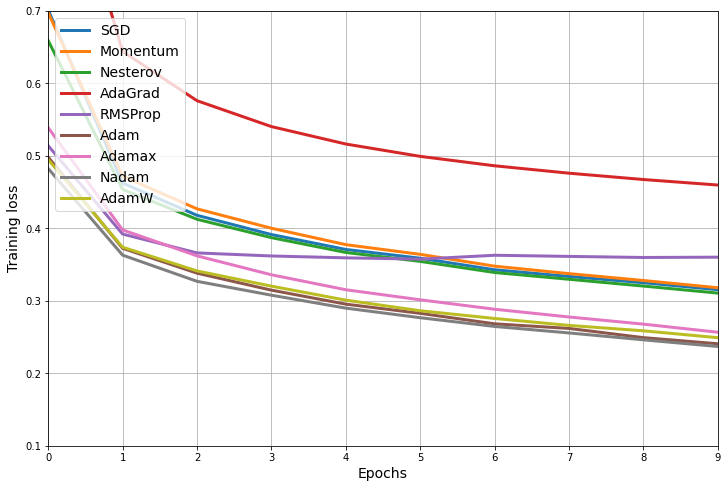

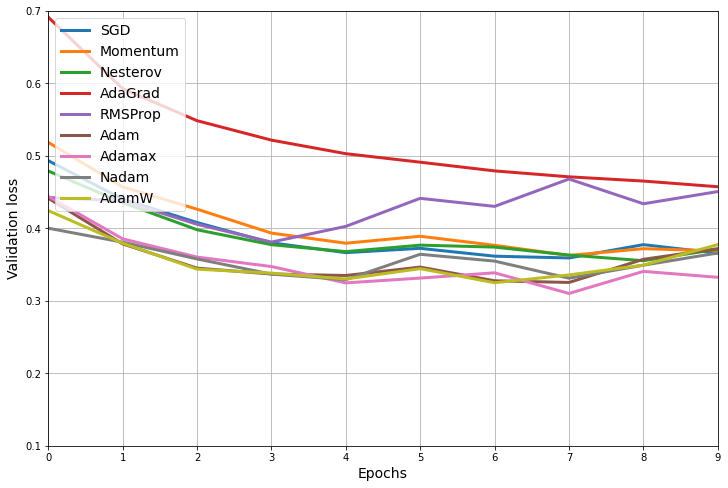

In [94]:
for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

## Learning Rate Scheduling


### Power Scheduling

lr = lr0 / (1 + steps / s)**c

Keras uses c=1 and s = 1 / decay

In [95]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)


In [96]:
history_power_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6851 - accuracy: 0.7689 - val_loss: 0.4870 - val_accuracy: 0.8342
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4734 - accuracy: 0.8354 - val_loss: 0.4449 - val_accuracy: 0.8402
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4269 - accuracy: 0.8503 - val_loss: 0.4149 - val_accuracy: 0.8574
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4030 - accuracy: 0.8587 - val_loss: 0.3948 - val_accuracy: 0.8634
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3843 - accuracy: 0.8645 - val_loss: 0.3812 - val_accuracy: 0.8658
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3699 - accuracy: 0.8691 - val_loss: 0.4006 - val_accuracy: 0.8620
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3604 - accuracy: 0.8719 - val_loss: 0.3685 - val_accuracy:

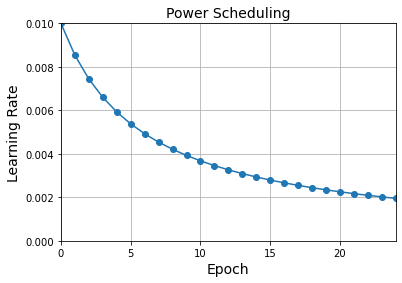

In [97]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
n_epochs = 25

epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling


lr = lr0 * 0.1 ** (epoch / s)



In [98]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [99]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [100]:
tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [101]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 10s 5ms/step - loss: 0.6928 - accuracy: 0.7642 - val_loss: 0.4946 - val_accuracy: 0.8190 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4709 - accuracy: 0.8335 - val_loss: 0.4757 - val_accuracy: 0.8260 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4237 - accuracy: 0.8485 - val_loss: 0.4211 - val_accuracy: 0.8526 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3990 - accuracy: 0.8572 - val_loss: 0.3980 - val_accuracy: 0.8552 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3793 - accuracy: 0.8648 - val_loss: 0.3874 - val_accuracy: 0.8584 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3645 - accuracy: 0.8685 - val_loss: 0.3871 - val_accuracy: 0.8590 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 9

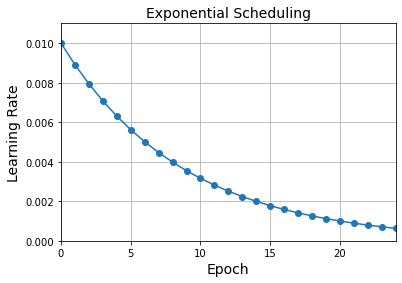

In [102]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [103]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

In [104]:
K = tf.keras.backend

class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

In [105]:
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [106]:
n_epochs = 25
batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 12s 6ms/step - loss: 0.6973 - accuracy: 0.7613 - val_loss: 0.5081 - val_accuracy: 0.8152 - lr: 0.0091
Epoch 2/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4764 - accuracy: 0.8323 - val_loss: 0.4616 - val_accuracy: 0.8330 - lr: 0.0083
Epoch 3/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4289 - accuracy: 0.8477 - val_loss: 0.4155 - val_accuracy: 0.8494 - lr: 0.0076
Epoch 4/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4038 - accuracy: 0.8571 - val_loss: 0.3924 - val_accuracy: 0.8544 - lr: 0.0069
Epoch 5/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3837 - accuracy: 0.8649 - val_loss: 0.3901 - val_accuracy: 0.8582 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3685 - accuracy: 0.8695 - val_loss: 0.3849 - val_accuracy: 0.8634 - lr: 0.0058
Epoch 7/25
1719/1719 [==============================

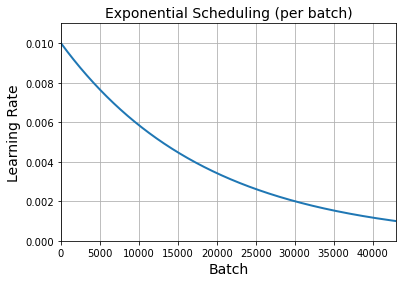

In [107]:
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
steps = np.arange(n_steps)
decay_rate = 0.1
lrs = lr0 * decay_rate ** (steps / n_steps)

plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling


In [108]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [109]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [110]:
n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 12s 6ms/step - loss: 0.5726 - accuracy: 0.7949 - val_loss: 0.5069 - val_accuracy: 0.8128 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4595 - accuracy: 0.8378 - val_loss: 0.4634 - val_accuracy: 0.8278 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4291 - accuracy: 0.8496 - val_loss: 0.4443 - val_accuracy: 0.8514 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4135 - accuracy: 0.8561 - val_loss: 0.4324 - val_accuracy: 0.8472 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4028 - accuracy: 0.8590 - val_loss: 0.4252 - val_accuracy: 0.8536 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3575 - accuracy: 0.8734 - val_loss: 0.3927 - val_accuracy: 0.8596 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================

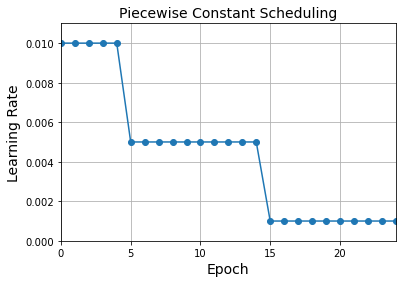

In [111]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling


In [112]:
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [113]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6789 - accuracy: 0.7668 - val_loss: 0.4880 - val_accuracy: 0.8316 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4692 - accuracy: 0.8351 - val_loss: 0.4566 - val_accuracy: 0.8394 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4221 - accuracy: 0.8503 - val_loss: 0.4222 - val_accuracy: 0.8516 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3979 - accuracy: 0.8595 - val_loss: 0.3853 - val_accuracy: 0.8626 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3779 - accuracy: 0.8660 - val_loss: 0.3787 - val_accuracy: 0.8622 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3611 - accuracy: 0.8700 - val_loss: 0.3853 - val_accuracy: 0.8624 - lr: 0.0100
Epoch 7/25
1719/1719 [==============================] - 9

### tf.keras schedulers


In [114]:
import math

batch_size = 32
n_epochs = 25
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
scheduled_learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=n_steps, decay_rate=0.1)
optimizer = tf.keras.optimizers.SGD(learning_rate=scheduled_learning_rate)

In [115]:
model = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.6796 - accuracy: 0.7667 - val_loss: 0.4850 - val_accuracy: 0.8256
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4727 - accuracy: 0.8342 - val_loss: 0.4501 - val_accuracy: 0.8350
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4250 - accuracy: 0.8490 - val_loss: 0.4223 - val_accuracy: 0.8504
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4008 - accuracy: 0.8586 - val_loss: 0.3866 - val_accuracy: 0.8636
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3810 - accuracy: 0.8651 - val_loss: 0.3740 - val_accuracy: 0.8630
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3656 - accuracy: 0.8699 - val_loss: 0.3757 - val_accuracy: 0.8674
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3545 - accuracy: 0.8737 - val_loss: 0.3595 - val_accuracy

In [116]:
# extra code – shows how to use PiecewiseConstantDecay
scheduled_learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1Cycle scheduling


The ExponentialLearningRate custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant factor. It also saves the learning rate and loss at each batch. Since logs["loss"] is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [117]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

The find_learning_rate() function trains the model using the ExponentialLearningRate callback, and it returns the learning rates and corresponding batch losses. At the end, it restores the model and its optimizer to their initial state.

In [118]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The plot_lr_vs_loss() function plots the learning rates vs the losses. The optimal learning rate to use as the maximum learning rate in 1cycle is near the bottom of the curve.

In [119]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

In [120]:

model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

430/430 [==============================] - 4s 7ms/step - loss: 1.8056 - accuracy: 0.3646


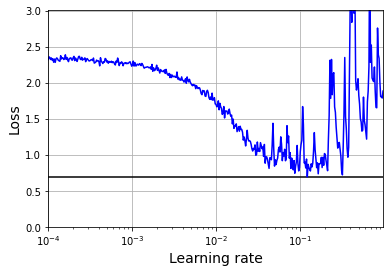

In [121]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

Looks like the max learning rate to use for 1cycle is around 10–1.

The OneCycleScheduler custom callback updates the learning rate at the beginning of each batch. It applies the logic described in the book: increase the learning rate linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.

In [122]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

In [123]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 4s 8ms/step - loss: 1.0065 - accuracy: 0.6727 - val_loss: 0.5899 - val_accuracy: 0.8008
Epoch 2/25
430/430 [==============================] - 3s 7ms/step - loss: 0.5696 - accuracy: 0.8011 - val_loss: 0.4939 - val_accuracy: 0.8242
Epoch 3/25
430/430 [==============================] - 3s 7ms/step - loss: 0.4956 - accuracy: 0.8258 - val_loss: 0.4617 - val_accuracy: 0.8388
Epoch 4/25
430/430 [==============================] - 3s 7ms/step - loss: 0.4505 - accuracy: 0.8408 - val_loss: 0.4329 - val_accuracy: 0.8436
Epoch 5/25
430/430 [==============================] - 3s 7ms/step - loss: 0.4240 - accuracy: 0.8489 - val_loss: 0.4053 - val_accuracy: 0.8472
Epoch 6/25
430/430 [==============================] - 3s 7ms/step - loss: 0.3955 - accuracy: 0.8594 - val_loss: 0.5431 - val_accuracy: 0.8000
Epoch 7/25
430/430 [==============================] - 3s 7ms/step - loss: 0.3816 - accuracy: 0.8617 - val_loss: 0.3906 - val_accuracy: 0.8604
Epoch 